In [1]:
#from pandas import Series, DataFrame
#import pandas as pd
#%pylab inline
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
import re
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


---
We will work with a dataset of bank branches (let's just call them ATMs) in Washington, D.C. Each row is one ATM for one bank (e.g., "Eagle Bank",  in column _name_), along with its _address_, _zipcode_, and such.

* When I say "ATM" or "bank branch", I am referring to the rows.
* When I say "bank", I am referring to things like "The Bank of New York Mellon", which may have multiple ATMs.
* When I say "address", I am referring to the "address" column.

In [2]:
df = pd.read_csv('bankLocOrig.csv')
df[:5]

,objectid,name,address,zipcode,address_id,y,x,diffx,diffy,latitude,longitude,location,ward
0,1,The Bank of New York Mellon,1250 H STREET NW,20005,240931,136856.85,397475.23,NaN,NaN,38.899560,-77.029106,POINT(-77.029105860000001 38.899560240000000),Ward 2
1,2,The National Capital Bank of Washington,316 PENNSYLVANIA AVENUE SE,20003,39317,135465.63,399901.19,NaN,NaN,38.887031,-77.001139,POINT(-77.001138889999993 38.887031239999999),Ward 6
2,11,American Bank,5600 CONNECTICUT AVENUE NW,20015,263862,144130.19,393416.98,NaN,NaN,38.965060,-77.075960,POINT(-77.075959609999998 38.965059650000001),Ward 3
3,101,Congressional Bank,2101 K STREET NW,20037,218615,137219.40,395935.38,NaN,NaN,38.902820,-77.046860,POINT(-77.046859580000003 38.902820450000000),Ward 2
4,102,Eagle Bank,700 7TH STREET NW,20001,243354,136753.17,398075.25,NaN,NaN,38.898628,-77.022188,POINT(-77.022188459999995 38.898627769999997),Ward 2


### Verify that all values in the objectid column are unique.

In [3]:
print 'Number of rows: ' + str(len(df))
print 'Number of unique values: ' + str(df['objectid'].nunique())

Number of rows: 234
Number of unique values: 234


### Report the number of distinct banks. Plot the number of ATMs of the top-10 most frequent banks.

37


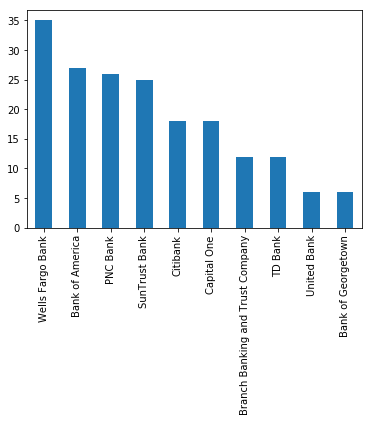

In [4]:
print df['name'].nunique()
df['name'].value_counts()[:10].plot(kind='bar')

### Which address has the most number of ATMs?

Some addresses have multiple ATMs, possibly from different banks.

In [5]:
df['address'].value_counts()[:1]

1350 I STREET NW    3
Name: address, dtype: int64

### Print out the number of zipcodes in each ward.
If a zipcode shows up in multiple wards, count it in each ward.

**Also** print out how many zipcodes span multiple wards.

In [6]:
temp = df[['zipcode','ward']].drop_duplicates()
print temp['ward'].value_counts()

print temp['zipcode'].value_counts().loc[lambda x : x>1]


Ward 2    9
Ward 6    4
Ward 3    4
Ward 5    3
Ward 4    3
Ward 1    3
Ward 7    2
Ward 8    2
Name: ward, dtype: int64
20001    3
20009    2
20020    2
20002    2
20015    2
20007    2
Name: zipcode, dtype: int64


### Find the "center of mass" (latitude, longitude) for banks with at least 20 ATM locations.
The center of mass for a bank is the average latitude and the average longitude of all its ATMs.
The output should be a **DataFrame**, whose index is the bank name, and whose only two columns are "avg latitude" and "avg longitude".

In [7]:
banks_20 = pd.DataFrame(df['name'].value_counts().loc[lambda x : x>19])
banks_20 = banks_20.reset_index().rename(columns=({'name':'Num_Atm','index':'name'}))
banks_20
temp = df[['name','latitude', 'longitude']]
copy = pd.merge(temp, banks_20, how='right', on='name')
#pd.pivot_table(copy,index=['name','Cleaned Descriptions'], values='Count',aggfunc=sum)
copy.groupby('name')[['latitude', 'longitude']].mean()


,latitude,longitude
name,,
Bank of America,38.906381,-77.031251
PNC Bank,38.910352,-77.033636
SunTrust Bank,38.906702,-77.030263
Wells Fargo Bank,38.908853,-77.033383


### Banks with multiple versions of the same name.
Some banks show up in the dataset with slightly different names. A bank called "XYZ" can sometimes show up with one or more spaces before XYZ, and one or more commas after XYZ.
* For example, one name could be "XYZ" and another could be ```" XYZ"``` or ```"       XYZ,,"```

Report all the banks for whom there are multiple variants of their name (report the "XYZ" name, with no beginning spaces and no commas after the name).

In [8]:
full_list = pd.DataFrame(df['name'].value_counts())
full_list = full_list.reset_index().rename(columns=({'name':'Num_Atm','index':'name'}))

In [9]:
cleaned_list = df
cleaned_list['name'] = cleaned_list['name'].str.lstrip()
cleaned_list['name'] = cleaned_list['name'].str.rstrip(',')
cleaned_list = pd.DataFrame(cleaned_list['name'].value_counts())
cleaned_list = cleaned_list.reset_index().rename(columns=({'name':'Num_Atm','index':'name'}))

tog = pd.merge(cleaned_list,full_list ,how='right', on='name',suffixes=[' Clean', ' Origional'])
tog['Num_Atm Clean'] = tog['Num_Atm Clean'].replace(np.NaN, 0)
tog['Diff'] = tog['Num_Atm Origional'] - tog['Num_Atm Clean']
mask = tog['Diff'] != 0

temp = tog[mask]
temp['name'] = temp['name'].str.rstrip(',')
temp['name'] = temp['name'].str.lstrip()
temp['name'].unique()

C:\Users\chris\Anaconda3\envs\py\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\chris\Anaconda3\envs\py\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array(['Manufacturers and Traders Trust Company', 'American Bank',
       'HSBC Bank USA', 'Wilmington Trust'], dtype=object)

### Print out all the unique addresses which have numbered streets.

A numbered street is like "7TH" street. So the address "700 7TH STREET NW" is an address with a numbered street.

Let's define a numbered street as starting with a number and ending with two capital letters in the end. For example, "123RD" starts with "123" and ends with "RD".

The "numbered street" can be any word in the address. It need not only be the second word.

In [94]:
#df['address'].str.extract('.*[0-9]+[A-Z][A-Z]\s')

def myfunc(s):
    return len(re.findall('.*[0-9]+[A-Z][A-Z]\s',s))>0

mask = df['address'].map(myfunc)
df['address'][mask]

4        700 7TH STREET NW
11     2000 11TH STREET NW
12     2000 14TH STREET NW
16      125 45TH STREET NE
27     3300 14TH STREET NW
29       833 7TH STREET NW
38      800 17TH STREET NW
46     3100 14TH STREET NW
49      1348 4TH STREET NE
50     3806 12TH STREET NE
55     1604 17TH STREET NW
66      900 17TH STREET NW
67     1020 19TH STREET NW
87       901 7TH STREET NW
88      605 14TH STREET NW
89     1030 15TH STREET NW
92      801 17TH STREET NW
99      1275 1ST STREET NE
100    5228 44TH STREET NW
101     600 14TH STREET NW
110    1146 19TH STREET NW
111    1804 14TH STREET NW
113     700 13TH STREET NW
114     1901 7TH STREET NW
116    3325 14TH STREET NW
124     888 17TH STREET NW
128    1934 14TH STREET NW
140     1200 1ST STREET NE
159    4301 49TH STREET NW
168     555 12TH STREET NW
169      444 8TH STREET NW
172    1115 30TH STREET NW
175    3101 14TH STREET NW
178     601 13TH STREET NW
192     925 15TH STREET NW
196    1100 17TH STREET NW
203     1075 5TH STREET NW
2

### Do a scatter plot of all ATM locations using the latitude and longitude columns. Ignore rows where the zipcode is 20520.

Color-code the dots in the scatter-plot by the zipcode, i.e., all ATMs in the same zipcode should have the same color. You can use any colormap, such as "Set1" or "tab20" or "bwr".

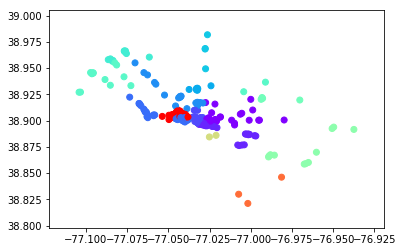

In [10]:
import matplotlib
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)

mask = df['zipcode'] == 20520
tmp = df[-mask]

colors = cm.rainbow(np.linspace(0, 1, len(tmp['zipcode'].unique())))

plt.scatter(tmp['longitude'], tmp['latitude'], c=tmp['zipcode'], cmap=matplotlib.colors.ListedColormap(colors))

#plot(tmp['longitude'], tmp['latitude'],marker='o', linestyle='None')

### Show two plots. The first plot is the frequency distribution of the top-10 zipcodes. The second is the frequency distribution of zipcodes for banks that appear only once in the dataset.

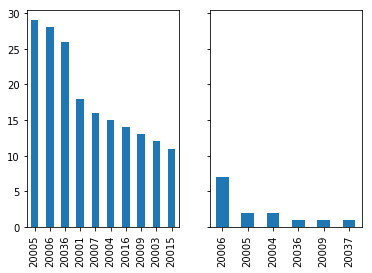

In [134]:
tn = pd.DataFrame(df['zipcode'].value_counts()[:10])
tn = tn.reset_index().rename(columns={'zipcode':'count', 'index':'zipcode'})


uno = pd.DataFrame(df['name'].value_counts().loc[lambda x : x<2])
uno = uno.reset_index().rename(columns={'name':'count', 'index':'name'})


uno2 = pd.merge(df,uno, how='inner', on='name')
uno3 = pd.DataFrame(uno2['zipcode'].value_counts())
uno3 = uno3.reset_index().rename(columns={'zipcode':'count', 'index':'zipcode'})

fig, (ax1, ax2) = subplots(nrows=1,
                           ncols=2,
                           sharey=True,
                           figsize=(6, 4))

df['zipcode'].value_counts()[:10].plot(kind='bar', ax = ax1)
uno2['zipcode'].value_counts().plot(kind='bar', ax = ax2)


### Bank domination of ward
A bank dominates a ward if it has the most branches among all banks in that ward. The degree of domination is the *fraction* of ATMs of this bank in this ward, as compared to the total number of ATMs of all banks in this ward.
* For example, if ward 1 has 50 "Bank of America", 20 "Congressional Bank", and 30 "Eagle Bank" ATMs, then ward 1 is dominated by "Bank of America", and the degree of domination is 50 / (50 + 20 + 30) = 0.5

For each ward, print out the degree to which it is dominated by any one bank.

In [156]:
df['Dummy'] = 1
temp = pd.DataFrame(df.groupby(['ward', 'name'])['Dummy'].agg('count'))


wtot = pd.DataFrame(temp.unstack().sum(axis=1))
wtot = wtot.reset_index().rename(columns={0:'count'})
wtot
temp = temp.reset_index()
dom = pd.merge(temp, wtot, on='ward')
dom['Dommination'] = dom['Dummy']/dom['count']

dom = dom.sort_values('Dommination', ascending=True).drop_duplicates('ward',keep='last')
dom[['ward','Dommination']]


,ward,Dommination
39,Ward 2,0.120301
76,Ward 7,0.142857
52,Ward 3,0.193548
53,Ward 4,0.200000
61,Ward 5,0.222222
0,Ward 1,0.235294
73,Ward 6,0.240000
83,Ward 8,0.285714


### Explore the relationship between (x, y) and (latitude, longitude).

* Create a column called "x_normalized", whose values are the "normalized" values of the column "x"
    * That is, if column x has mean 10000 and standard deviation 50, then the values of x_normalized are (x-10000) / 50
* Repeat this to create y_normalized, latitude_normalized, and longitude_normalized.
* Now run a linear regression to predict y_normalized using all the other normalized columns.


In [164]:
df['x_normalized'] = 1.0*(df['x']-df['x'].mean())/df['x'].std()
df['y_normalized'] = 1.0*(df['y']-df['y'].mean())/df['y'].std()
df['latitude_normalized'] = 1.0*(df['latitude']-df['latitude'].mean())/df['latitude'].std()
df['longitude_normalized'] = 1.0*(df['longitude']-df['longitude'].mean())/df['longitude'].std()

import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('y_normalized ~ longitude_normalized + latitude_normalized + x_normalized', df, return_type='dataframe')
result = sm.OLS(y, X).fit()

result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           y_normalized   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.834e+09
Date:                Fri, 16 Aug 2019   Prob (F-statistic):               0.00
Time:                        11:35:32   Log-Likelihood:                 1707.2
No. Observations:                 234   AIC:                            -3406.
Df Residuals:                     230   BIC:                            -3393.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             6.359e-14   1.08e-05   5.88e-09      1.000   -2.13e-05    2.13e-05
longitude_normalized    -0.4181      0.025    -16.568      0.000      -0.468      -0.368
latitude_normalized      0.9997   1.75e-05   5.72e+04      0.000       1.000       1.000
x_normalized             0.4177      0.025     16.557      0.000       0.368       0.467
==============================================================================
Omnibus:                      166.124   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1545.478
Skew:                           2.791   Prob(JB):                         0.00
Kurtosis:                      14.285   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""